In [1]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
# import datetime
import zipfile
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5
from lakeanalysis.nsidc import download_is2
from icelakes.nsidc import download_granule
from icelakes.detection import read_atl03
from ed.edcreds import getedcreds

In [2]:
dfl = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
dfl['qual_nonzero'] = ['good data' if (x > 0) else 'bad data' for x in dfl.lake_quality]

In [66]:
sheet_totals = dfl.groupby(by='ice_sheet')[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})
sheet_totals

,lake_count
ice_sheet,
AIS,748
GrIS,500


In [67]:
total_counts = dfl.groupby(by='qual_nonzero')[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})
total_counts

,lake_count
qual_nonzero,
bad data,777
good data,471


In [94]:
sheet_counts = dfl.groupby(by=['ice_sheet','qual_nonzero'])[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})
sheet_counts['percent'] = np.nan
for sheet in ['AIS', 'GrIS']:
    sheet_counts.loc[sheet, 'percent'] = np.array(sheet_counts.loc[sheet].lake_count / sheet_counts.loc[sheet].lake_count.sum() * 100)
sheet_counts['percent'] = sheet_counts.apply(lambda x: '%.1f %%' % x.percent, axis=1)
sheet_counts

lake_count percent
ice_sheet qual_nonzero                    
AIS       bad data             582  77.8 %
          good data            166  22.2 %
GrIS      bad data             195  39.0 %
          good data            305  61.0 %

In [116]:
dfl.groupby(by=['ice_sheet','melt_season'])[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})
dfl.groupby(by=['ice_sheet','melt_season','qual_nonzero'])[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})

lake_count
ice_sheet melt_season qual_nonzero            
AIS       2018-19     bad data             556
                      good data            164
          2020-21     bad data              26
                      good data              2
GrIS      2019        bad data             129
                      good data            196
          2020        bad data              66
                      good data            109

In [32]:
dfl['count_nnz'] = dfl.apply(lambda x: 1 if (x.lake_quality > 0) else 0, axis=1)
grp = dfl.groupby(by=['ice_sheet','melt_season'])[['count_nnz']]
dfp = grp.sum()
dfp['total']= grp.count()
dfp['perc_good'] = dfp.apply(lambda x: '%d %%' % np.round((x.count_nnz / x.total) * 100), axis=1)
dfp

count_nnz  total perc_good
ice_sheet melt_season                            
AIS       2018-19            164    720      23 %
          2020-21              2     28       7 %
GrIS      2019               196    325      60 %
          2020               109    175      62 %

______________________________________________________________________________________
2020-21 max depth: 14.5
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09998619_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210204190842_06531012_006_01_gt3r_0001.h5


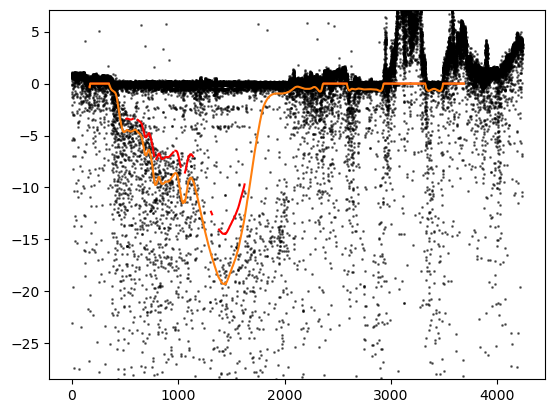

______________________________________________________________________________________
2020-21 max depth: 7.1
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999870_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210204190842_06531012_006_01_gt3l_0000.h5


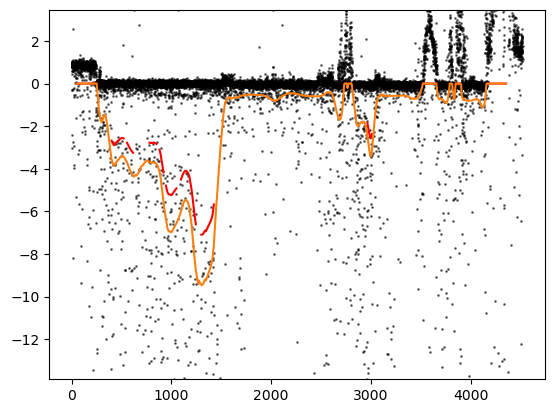

______________________________________________________________________________________
2020-21 max depth: 2.4
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210111071058_02791010_006_01_gt3r_0004.h5


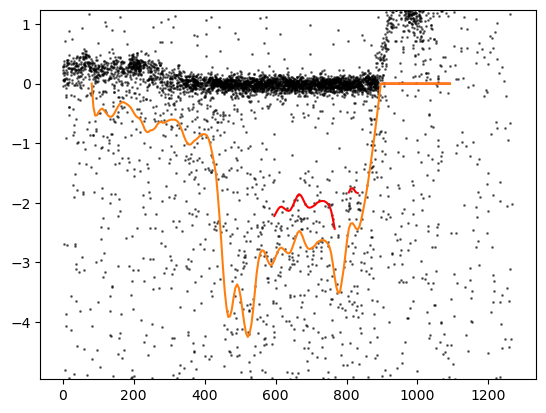

______________________________________________________________________________________
2020-21 max depth: 1.8
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999934_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210111071058_02791010_006_01_gt3l_0002.h5


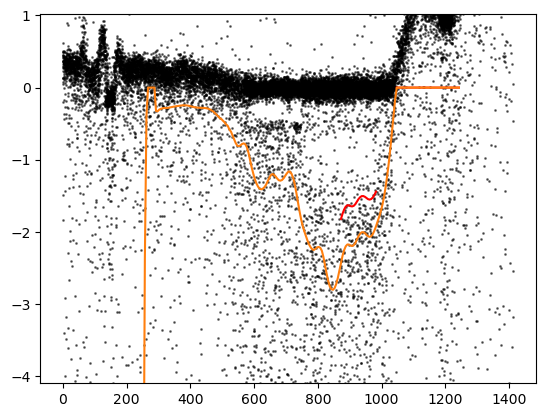

______________________________________________________________________________________
2020-21 max depth: 0.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999245_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210123064559_04621010_006_01_gt2r_0000.h5


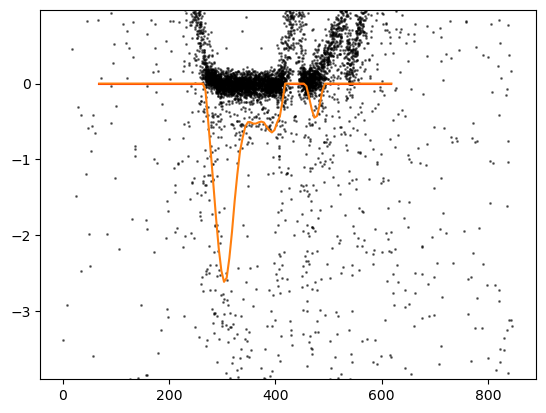

______________________________________________________________________________________
2020-21 max depth: 0.1
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210208190023_07141012_006_01_gt3r_0001.h5


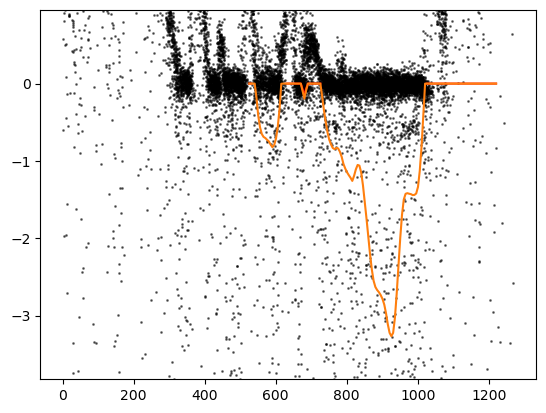

______________________________________________________________________________________
2020-21 max depth: 1.3
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999907_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210111071058_02791010_006_01_gt3r_0003.h5


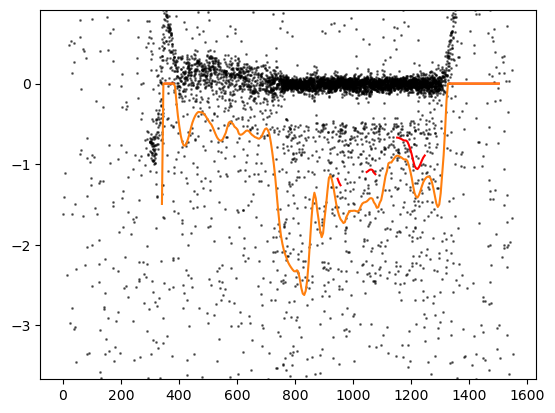

______________________________________________________________________________________
2020-21 max depth: 0.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210208190023_07141012_006_01_gt3r_0002.h5


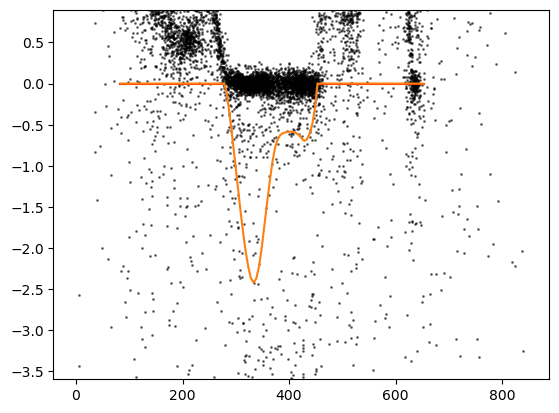

______________________________________________________________________________________
2020-21 max depth: 0.5
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999437_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20201118095027_08430910_006_01_gt2r_0000.h5


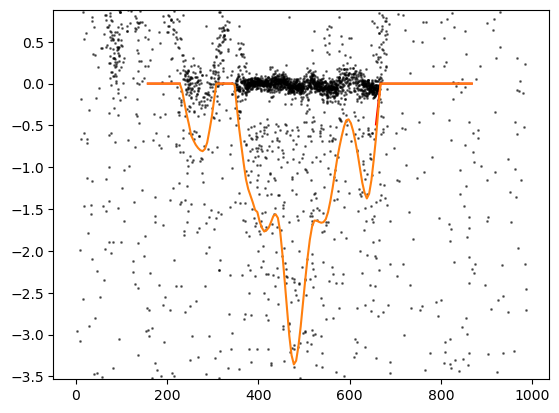

______________________________________________________________________________________
2020-21 max depth: 0.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210127192522_05311012_006_01_gt1r_0001.h5


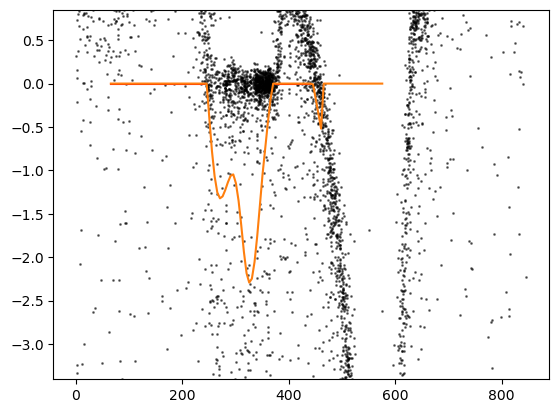

______________________________________________________________________________________
2020-21 max depth: 0.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210127192522_05311012_006_01_gt1l_0000.h5


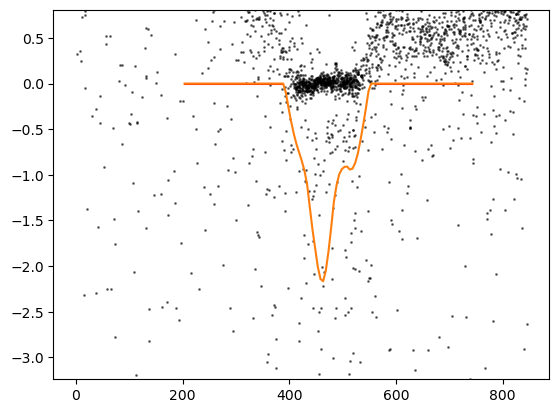

______________________________________________________________________________________
2020-21 max depth: 0.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210204190842_06531012_006_01_gt3r_0002.h5


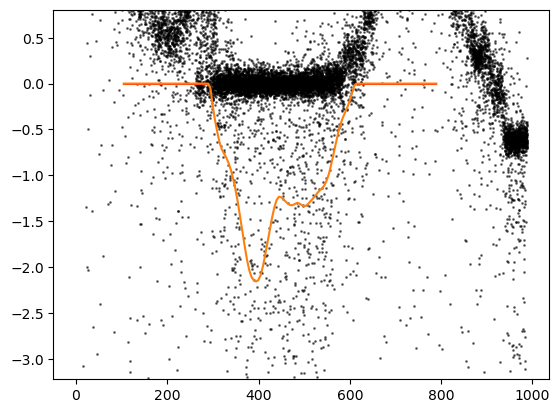

______________________________________________________________________________________
2020-21 max depth: 0.6
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210111195841_02871012_006_01_gt1l_0000.h5


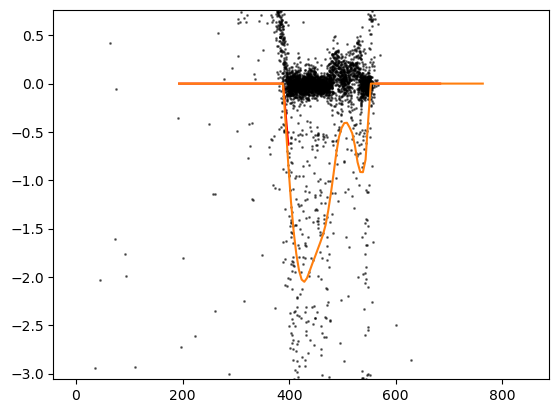

______________________________________________________________________________________
2020-21 max depth: 0.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999733_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210106203237_02111012_006_01_gt1l_0000.h5


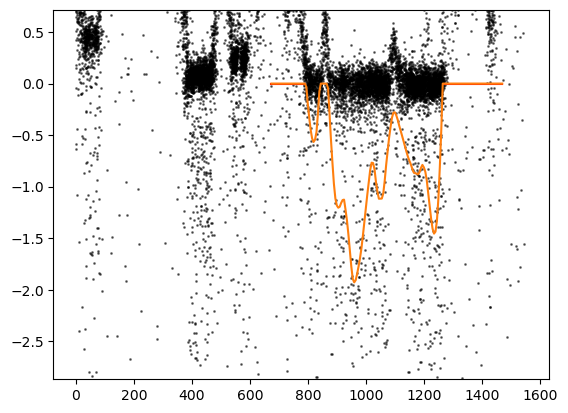

______________________________________________________________________________________
2020-21 max depth: 0.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20201114224630_07900912_006_01_gt1l_0000.h5


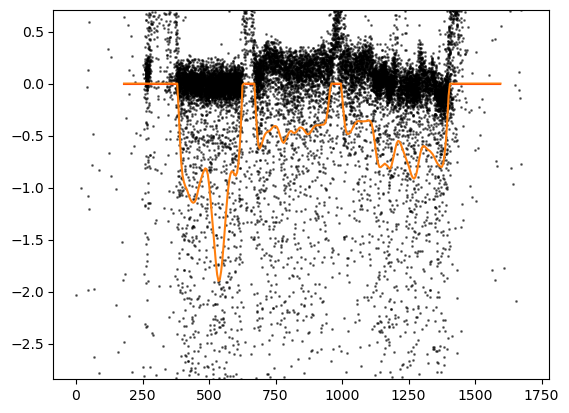

______________________________________________________________________________________
2020-21 max depth: 1.2
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210107071914_02181010_006_01_gt2l_0001.h5


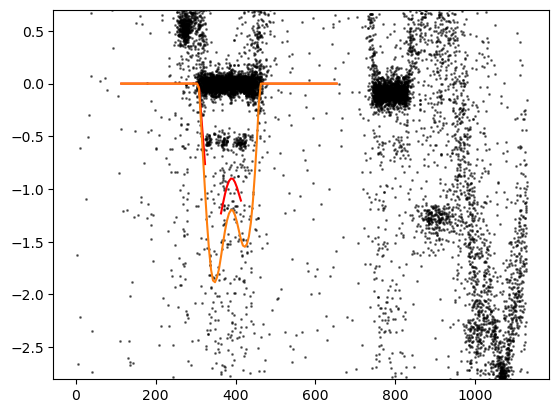

______________________________________________________________________________________
2020-21 max depth: 1.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20201225080953_00201010_006_01_gt1l_0000.h5


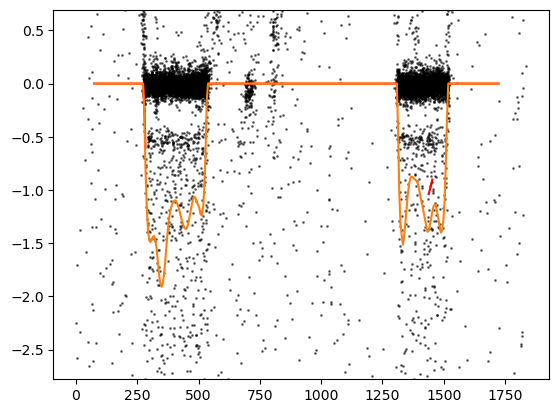

______________________________________________________________________________________
2020-21 max depth: 1.4
lake quality: 1.23
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09992092_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20201225080953_00201010_006_01_gt3l_0001.h5


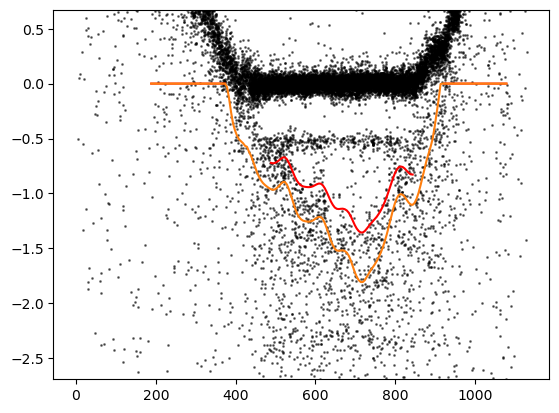

______________________________________________________________________________________
2020-21 max depth: 0.7
lake quality: 0.13
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210313172806_12171012_006_01_gt3r_0001.h5


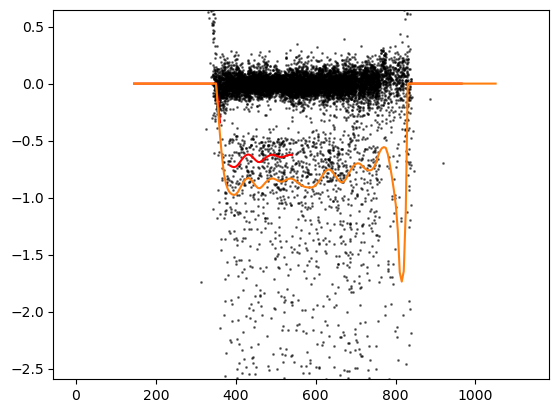

______________________________________________________________________________________
2020-21 max depth: 0.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210103201518_01651012_006_01_gt1r_0000.h5


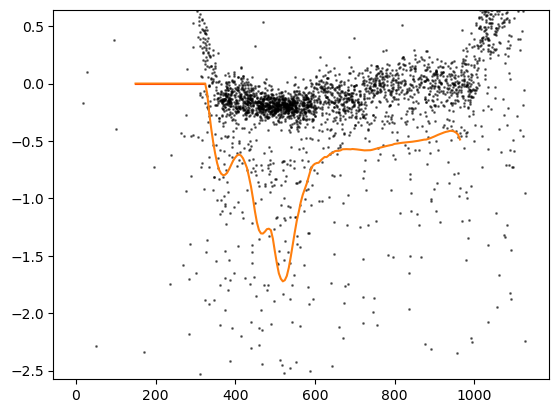

______________________________________________________________________________________
2020-21 max depth: 0.1
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210106203237_02111012_006_01_gt3r_0001.h5


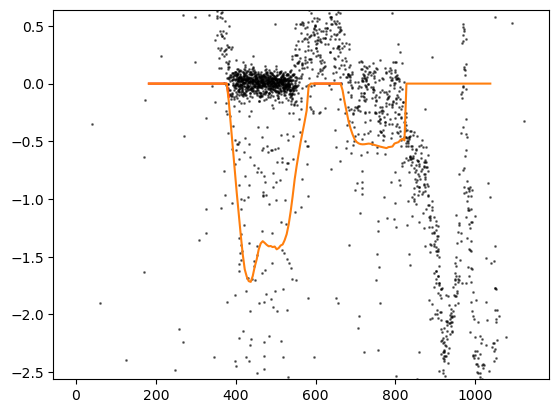

______________________________________________________________________________________
2020-21 max depth: 0.9
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999930_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210119194158_04091012_006_01_gt3r_0005.h5


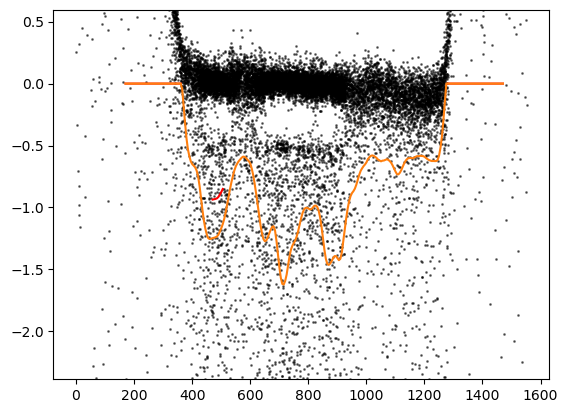

______________________________________________________________________________________
2020-21 max depth: 0.0
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210205184304_06681012_006_01_gt3r_0000.h5


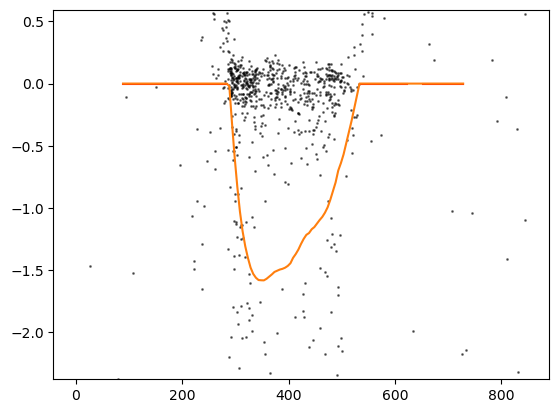

______________________________________________________________________________________
2020-21 max depth: 1.1
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999992_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210119194158_04091012_006_01_gt3l_0001.h5


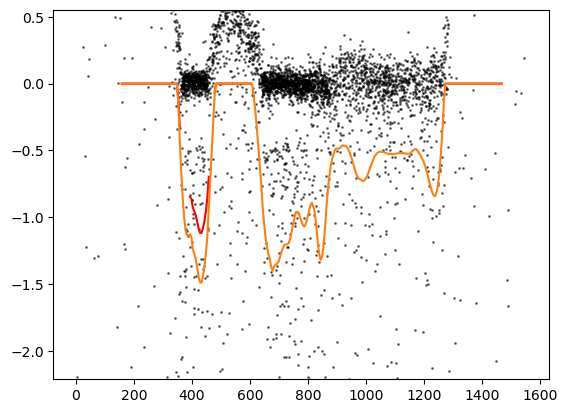

______________________________________________________________________________________
2020-21 max depth: 1.1
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999803_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210107071914_02181010_006_01_gt1l_0000.h5


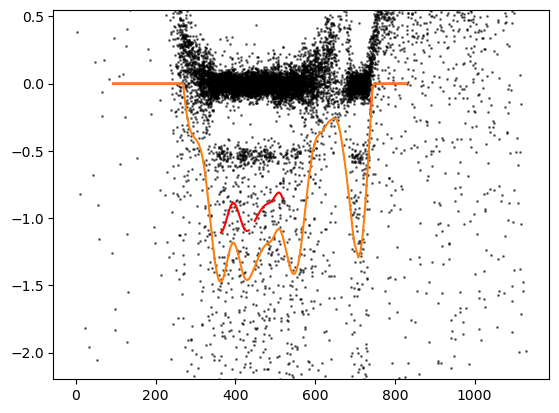

______________________________________________________________________________________
2020-21 max depth: 1.1
lake quality: 0.00
/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210111195841_02871012_006_01_gt2l_0001.h5


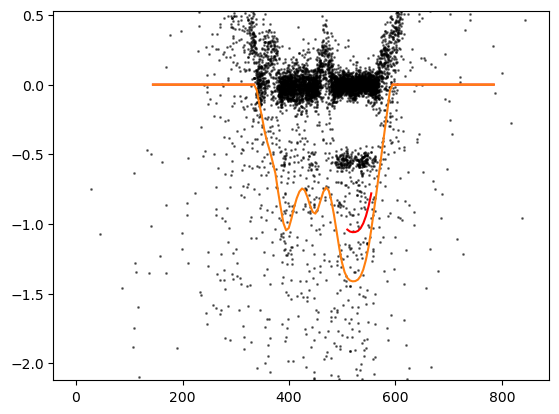

ValueError: Axis limits cannot be NaN or Inf

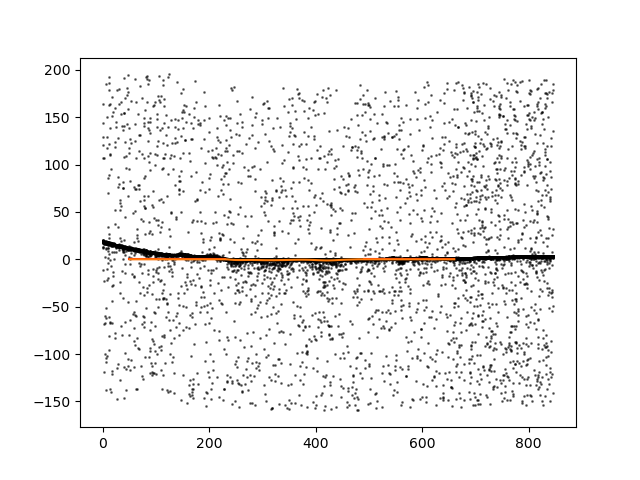

In [25]:
melt_season = '2020-21'
dfs = dfl[dfl.melt_season == melt_season].copy().sort_values(by='depth_95th_pctl', ascending=False)
for i in range(30):
    fn = dfs.iloc[i].file_name
    # fn = 'data/validation/fluidsurrf_out/lake_09989-09335_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0010.h5'
    d95 = dfs.iloc[i].depth_95th_pctl
    lk = dictobj(read_melt_lake_h5(fn))
    fig, ax = plt.subplots()
    dfd = lk.depth_data
    df = lk.photon_data
    hsurf = lk.surface_elevation
    ax.scatter(df.xatc, df.h - hsurf, s=1, c='k', alpha=0.5)
    sel = dfd.conf > 0.5
    depth = dfd.depth.copy()
    depth[~sel] = np.nan
    ax.plot(dfd.xatc, -depth, 'r-')
    ax.plot(dfd.xatc, -dfd.depth*1.333, color='C1')
    ax.set_ylim((-d95*2, d95*0.5))
    plt.close(fig)
    print('______________________________________________________________________________________')
    print('%s max depth: %.1f' % (melt_season, np.nanmax(depth)))
    print('lake quality: %.2f' % lk.lake_quality)
    print(fn)
    display(fig)
    

In [121]:
dfhq = dfl[dfl.lake_quality > 0]
dfhq.groupby(by=['ice_sheet','melt_season'])[['depth_95th_pctl']].max()

depth_95th_pctl
ice_sheet melt_season                 
AIS       2018-19            18.649632
          2020-21             1.346338
GrIS      2019               22.789588
          2020               13.749298

In [83]:
for sheet in ['AIS', 'GrIS']:
    sheet_counts.loc[sheet, 'percent'] = sheet_counts.loc[sheet].lake_count / sheet_counts.loc[sheet].lake_count.sum() * 100

qual_nonzero
bad data     46.634615
good data    13.301282
Name: percent, dtype: float64

In [86]:
sheet_counts.loc['AIS'].lake_count / sheet_counts.loc['AIS'].lake_count.sum() * 100

qual_nonzero
bad data     77.807487
good data    22.192513
Name: lake_count, dtype: float64

In [4]:
granule_counts = dfl[['granule_id', 'ice_sheet']].groupby(by='granule_id')\
    .count().rename(columns={'ice_sheet': 'count'}).sort_values(by='count', ascending=False)
info = dfl.groupby(by='granule_id')[['ice_sheet', 'melt_season']].first()
count_info =  pd.concat((granule_counts, info), axis=1)
count_info.iloc[:20]

,count,ice_sheet,melt_season
granule_id,,,
ATL03_20190102184312_00810210_006_02.h5,121,AIS,2018-19
ATL03_20190103073055_00890212_006_02.h5,91,AIS,2018-19
ATL03_20181229185130_00200210_006_02.h5,61,AIS,2018-19
ATL03_20190127172740_04620210_006_02.h5,60,AIS,2018-19
ATL03_20190131171923_05230210_006_02.h5,46,AIS,2018-19
ATL03_20190617064249_12220303_006_02.h5,46,GrIS,2019
ATL03_20200713115804_02770803_006_01.h5,36,GrIS,2020
ATL03_20190201060707_05310212_006_02.h5,34,AIS,2018-19
ATL03_20190123173555_04010210_006_02.h5,33,AIS,2018-19


In [5]:
dfl['granule_gtx'] = dfl.apply(lambda x: x.granule_id[:-3] + '_' + x.gtx, axis=1)
gtx_counts = dfl[['granule_gtx', 'ice_sheet']].groupby(by='granule_gtx')\
    .count().rename(columns={'ice_sheet': 'count'}).sort_values(by='count', ascending=False)
info_gtx = dfl.groupby(by='granule_gtx')[['ice_sheet', 'melt_season']].first()
gtx_counts = pd.concat((gtx_counts, info_gtx), axis=1)

gtx_counts[gtx_counts.melt_season == '2018-19'].iloc[:30]

,count,ice_sheet,melt_season
granule_gtx,,,
ATL03_20190102184312_00810210_006_02_gt1r,31,AIS,2018-19
ATL03_20190102184312_00810210_006_02_gt3r,23,AIS,2018-19
ATL03_20190103073055_00890212_006_02_gt2l,20,AIS,2018-19
ATL03_20190102184312_00810210_006_02_gt3l,19,AIS,2018-19
ATL03_20181229185130_00200210_006_02_gt3r,19,AIS,2018-19
ATL03_20190102184312_00810210_006_02_gt1l,17,AIS,2018-19
ATL03_20190102184312_00810210_006_02_gt2r,17,AIS,2018-19
ATL03_20190103073055_00890212_006_02_gt3l,16,AIS,2018-19
ATL03_20190103073055_00890212_006_02_gt1l,16,AIS,2018-19


# Use these granules / gtx for validation:
- ATL03_20190102184312_00810210_006_02_gt2l

In [8]:
# download ATL03 data from NSIDC
granule_id = 'ATL03_20190102184312_00810210_006_02.h5'
gtx = 'gt2l'
uid, pwd, email = getedcreds()

atl03_dir = 'data/atl03_raw'
fn_atl03 = atl03_dir + '/' + granule_id
fn_valid = atl03_dir + '/' + 'validation_' + granule_id
# geojson = 'geojsons/simplified_GRE_2000_CW.geojson'
geojson = 'geojsons/simplified_ANT_1000_East_B-C.geojson'
if not os.path.isfile(fn_valid):
#if True:
    thisfile, status = download_granule(granule_id, gtxs='all', geojson=geojson, granule_output_path=atl03_dir, 
                                        uid=uid, pwd=pwd, vars_sub='default', spatial_sub=True)
    os.rename(thisfile, fn_valid)
    print(thisfile)

# read in ATL03 data from NSIDC
beams_available, ancillary, dfs, dfs_telem = read_atl03(fn_valid, geoid_h=True, gtxs_to_read=gtx)
df03 = dfs[gtx]

  reading in data/atl03_raw/validation_ATL03_20190102184312_00810210_006_02.h5
  reading in beam: gt2l  --> done.


In [24]:
searchfor = 'ATL03_20190102184312_00810210_006_02_gt2l'
searchdir = 'data/validation/fluidsurrf_out/'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('.h5' in f)]
print(len(filelist))

16


In [31]:
vars(lk).keys()

dict_keys(['beam_number', 'beam_strength', 'cycle_number', 'dead_time', 'dead_time_meters', 'detection_quality', 'full_lat_extent_detection', 'granule_id', 'gtx', 'ice_sheet', 'lake_id', 'lake_quality', 'lat', 'lat_max', 'lat_min', 'lat_str', 'lat_surface_extent_detection', 'len_subsegs', 'length_extent', 'length_water_surfaces', 'lon', 'lon_max', 'lon_min', 'lon_str', 'main_peak', 'max_depth', 'melt_season', 'mframe_end', 'mframe_start', 'n_photons_where_water', 'n_subsegs_per_mframe', 'oaurl', 'polygon_filename', 'polygon_name', 'rgt', 'sc_orient', 'surface_elevation', 'surface_extent_detection', 'depth_data', 'photon_data', 'mframe_data', 'detection_2nd_returns', 'detection_quality_info', 'date_time'])

In [34]:
dfds = []
# for i,fn in enumerate(dfl[dfl.granule_gtx=='ATL03_20190102184312_00810210_006_02_gt2l'].file_name):
for i,fn in enumerate(filelist):
    lk = dictobj(read_melt_lake_h5(fn))
    thisdf = lk.depth_data.copy()
    thisdf['lakeid'] = i
    thisdf['lake_quality'] = lk.lake_quality
    thisdf['fn'] = fn
    dfds.append(thisdf)
    # print(fn)
    # fig,ax = plt.subplots()
    # dfp = lk.photon_data
    # ax.scatter(dfp.lat, dfp.)
dfd = pd.concat(dfds)

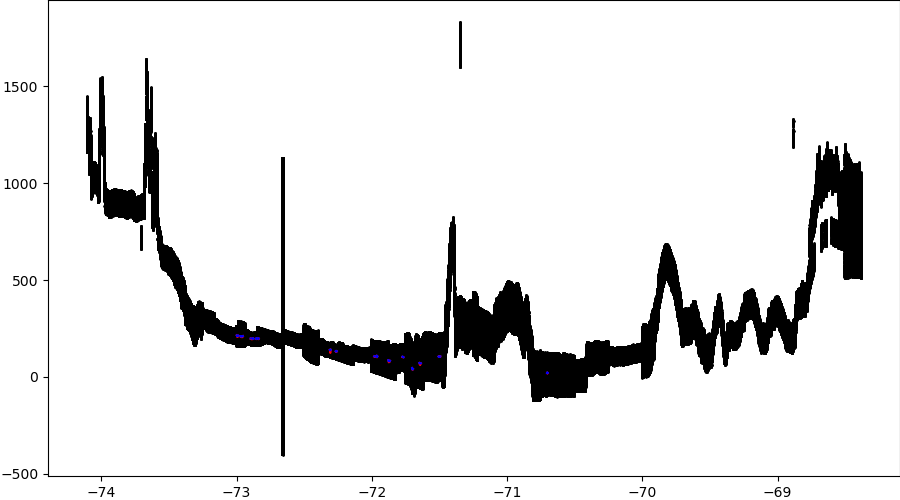

In [26]:
fig,ax = plt.subplots(figsize=[9,5])
ax.scatter(df03.lat, df03.h, s=1, c='k')
for dfdepth in dfds:
    ax.plot(dfdepth.lat, dfdepth.h_fit_bed, 'r-')
    ax.plot(dfdepth.lat, dfdepth.h_fit_surf, 'b-')
fig.tight_layout(pad=0)

In [17]:
print("{'xl': (%.7f, %.7f), 'yl': (%.2f, %.2f), 'qual': }," % tuple(list(ax.get_xlim()) + list(ax.get_ylim())))

{'xl': (-72.3094160, -72.3051110), 'yl': (118.68, 141.14), 'qual': },


In [27]:
locs = [
    {'xl': (-72.9975630, -72.9886089), 'yl': (201.52, 215.75), 'qual': 2},
    {'xl': (-72.9698436, -72.9544389), 'yl': (200.82, 212.44), 'qual': 2},
    {'xl': (-72.8933728, -72.8766600), 'yl': (190.74, 200.59), 'qual': 2},
    {'xl': (-72.8408549, -72.8372124), 'yl': (187.82, 202.83), 'qual': 2},
    {'xl': (-72.3118863, -72.3027743), 'yl': (110.10, 151.50), 'qual': 2},
    {'xl': (-72.2672962, -72.2582180), 'yl': (121.34, 133.88), 'qual': 2},
    {'xl': (-71.9282961, -71.9263007), 'yl': (93.02, 100.83), 'qual': 2},
    {'xl': (-71.8775898, -71.8661434), 'yl': (68.94, 85.94), 'qual': 2},
    {'xl': (-71.6871403, -71.6840616), 'yl': (11.22, 45.08), 'qual': 2},
    {'xl': (-71.6499030, -71.6359531), 'yl': (54.70, 76.32), 'qual': 2},
    {'xl': (-71.5295575, -71.5269419), 'yl': (89.06, 99.45), 'qual': 2},
    {'xl': (-71.5061186, -71.4941196), 'yl': (96.10, 108.87), 'qual': 2},
    {'xl': (-70.7064828, -70.6999293), 'yl': (13.39, 23.78), 'qual': 2},
    # #
    # {'xl': (-73.9704380, -73.9680810), 'yl': (902.67, 913.98), 'qual': 0},
    # {'xl': (-73.5833913, -73.5805833), 'yl': (706.45, 727.30), 'qual': 0},
    # {'xl': (-73.5554598, -73.5519779), 'yl': (615.50, 631.60), 'qual': 1},
    # {'xl': (-73.3138660, -73.3087011), 'yl': (236.22, 254.69), 'qual': 1},
    # {'xl': (-73.1239353, -73.1197628), 'yl': (230.30, 243.76), 'qual': 1},
    # {'xl': (-72.8563611, -72.8515682), 'yl': (187.67, 202.21), 'qual': 0},
    # {'xl': (-72.3461232, -72.3416983), 'yl': (130.81, 147.51), 'qual': 1},
    # {'xl': (-71.9827610, -71.9749346), 'yl': (98.64, 108.18), 'qual': 1},
    # {'xl': (-71.9634995, -71.9592142), 'yl': (87.94, 109.26), 'qual': 1},
    # {'xl': (-71.9524673, -71.9489281), 'yl': (95.18, 105.38), 'qual': 1},
    # {'xl': (-71.9077563, -71.9046551), 'yl': (92.41, 101.87), 'qual': 1},
    # {'xl': (-71.7020713, -71.6960718), 'yl': (26.85, 46.31), 'qual': 1},
    # {'xl': (-71.5998209, -71.5953100), 'yl': (99.02, 107.49), 'qual': 1},
    # {'xl': (-71.1067250, -71.0998121), 'yl': (176.20, 210.52), 'qual': 1},
    # {'xl': (-70.6961783, -70.6940808), 'yl': (2.76, 20.77), 'qual': 1},
]

In [28]:
plt.close('all')

data/validation/fluidsurrf_out/lake_09962-08707_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0015.h5
-72.99308453667332


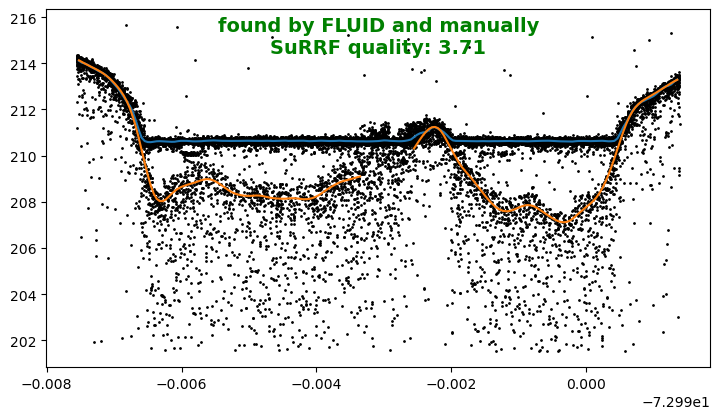

__________________________________________________________________
data/validation/fluidsurrf_out/lake_09994-08543_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0014.h5
-72.96214189457139


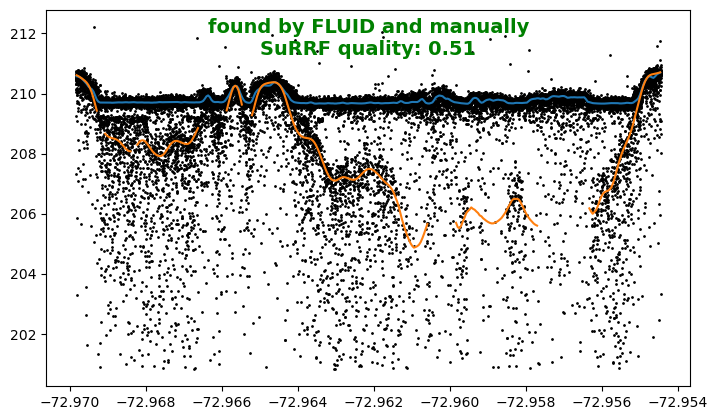

__________________________________________________________________
data/validation/fluidsurrf_out/lake_09950-08795_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0013.h5
-72.8850268434744


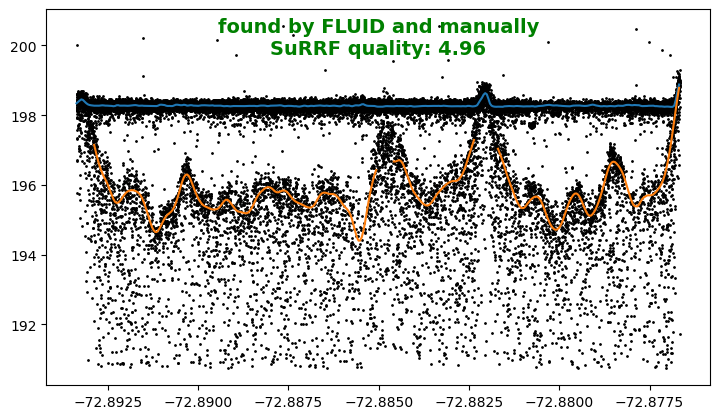

__________________________________________________________________
data/validation/fluidsurrf_out/lake_09997-09836_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0011.h5
-72.83903997495092


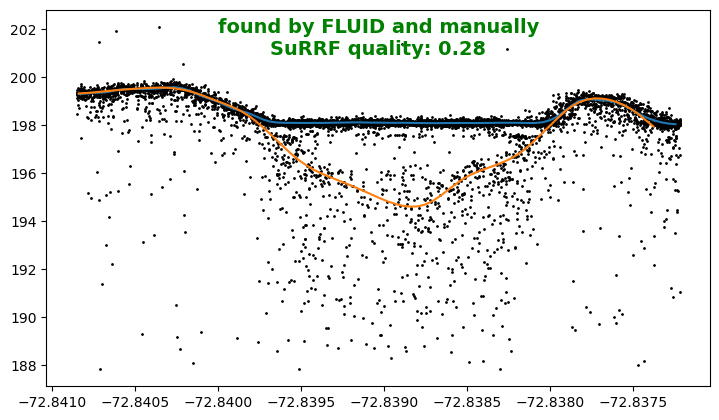

__________________________________________________________________
data/validation/fluidsurrf_out/lake_09989-09335_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0010.h5
-72.30738945565481


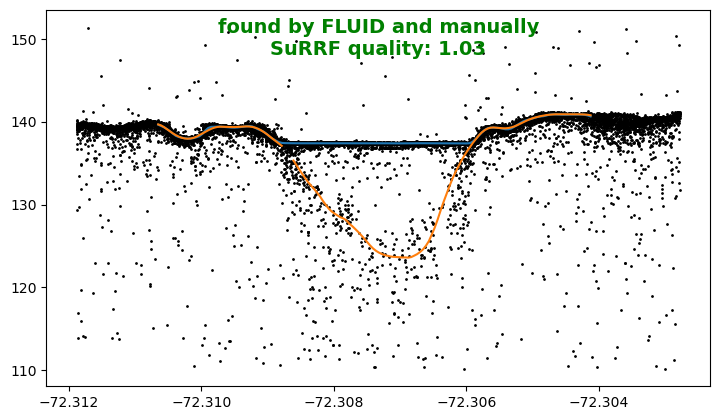

__________________________________________________________________
data/validation/fluidsurrf_out/lake_10000-10000_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0009.h5
-72.26272754833296


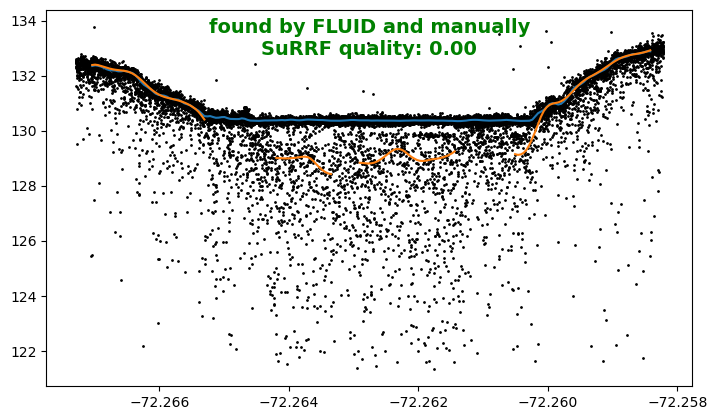

__________________________________________________________________


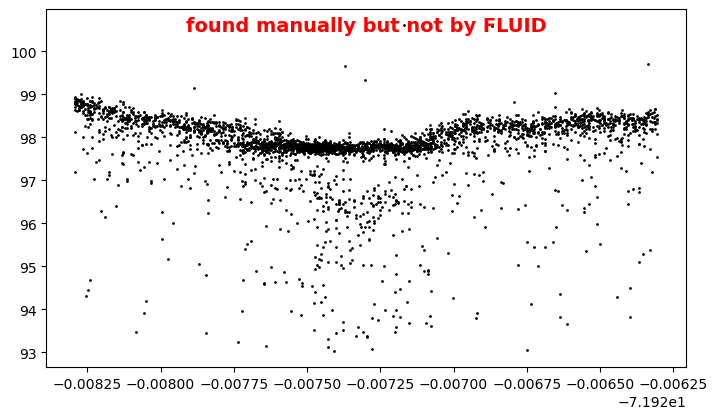

__________________________________________________________________
data/validation/fluidsurrf_out/lake_09977-08181_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0006.h5
-71.87185808920655


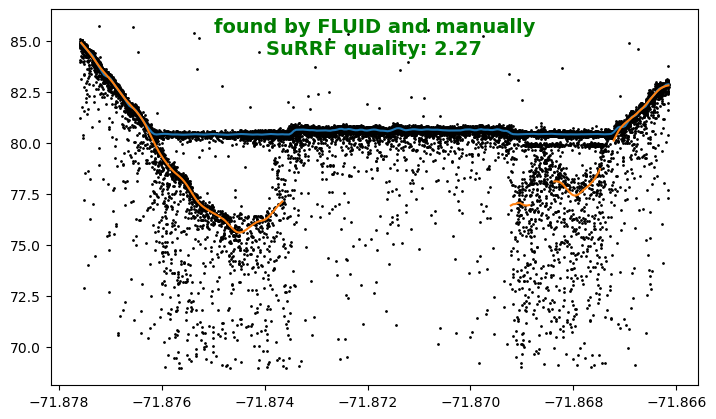

__________________________________________________________________


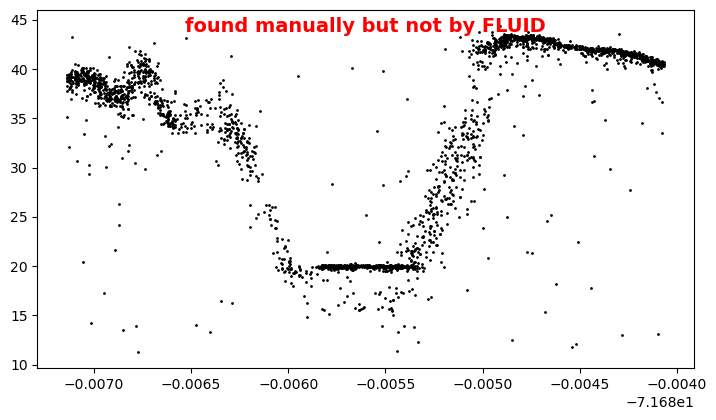

__________________________________________________________________
data/validation/fluidsurrf_out/lake_09944-08012_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0003.h5
-71.64294489767362


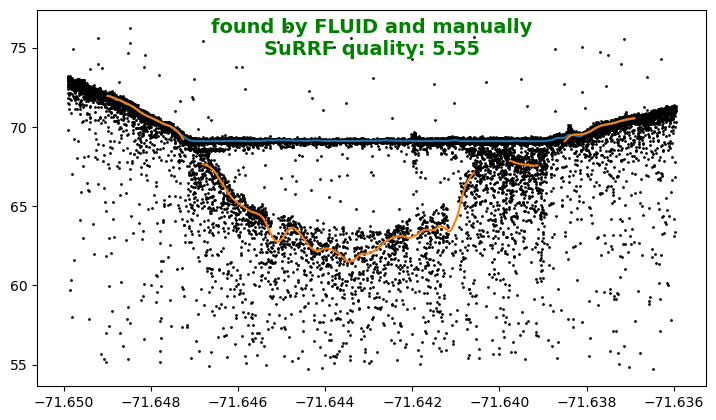

__________________________________________________________________


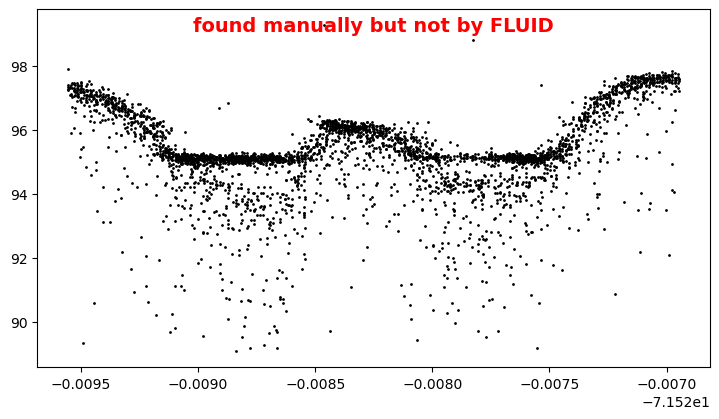

__________________________________________________________________
data/validation/fluidsurrf_out/lake_10000-09952_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0001.h5
-71.5001034534741


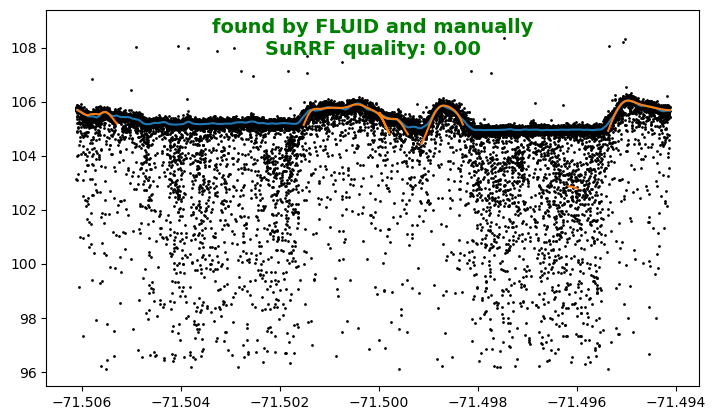

__________________________________________________________________
data/validation/fluidsurrf_out/lake_09974-10000_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0000.h5
-70.70218242673494


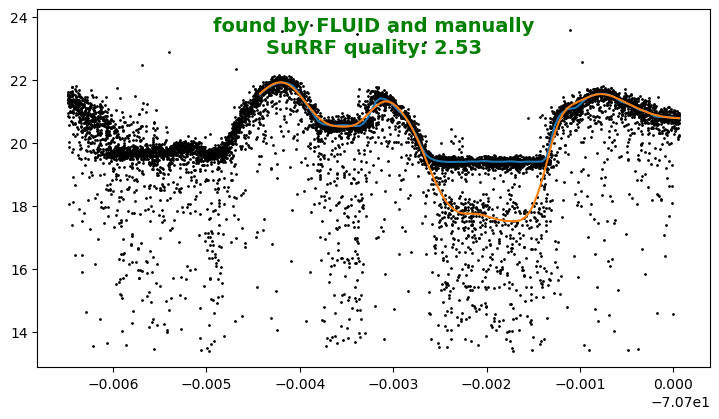

__________________________________________________________________


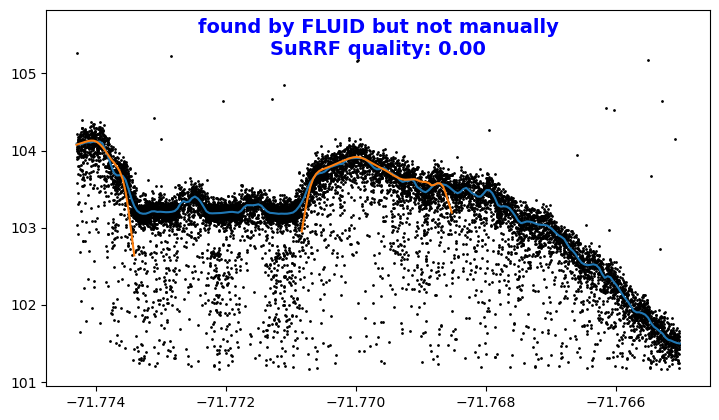

__________________________________________________________________


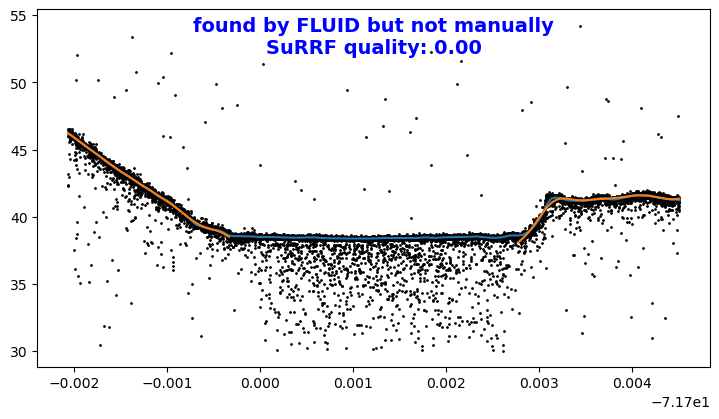

__________________________________________________________________


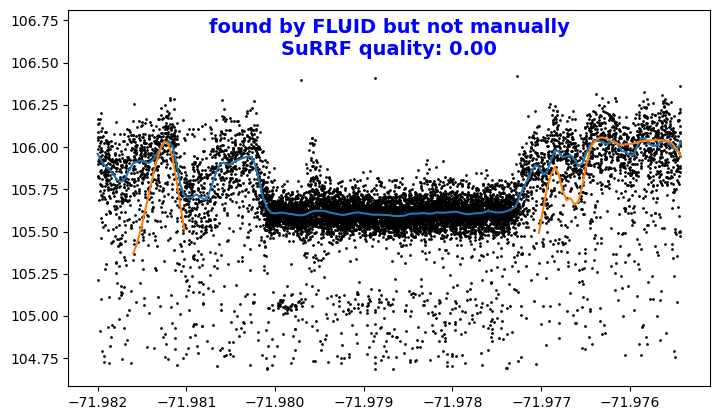

__________________________________________________________________


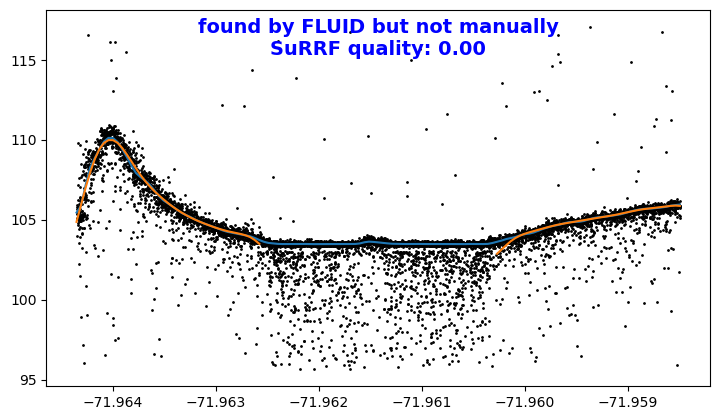

__________________________________________________________________


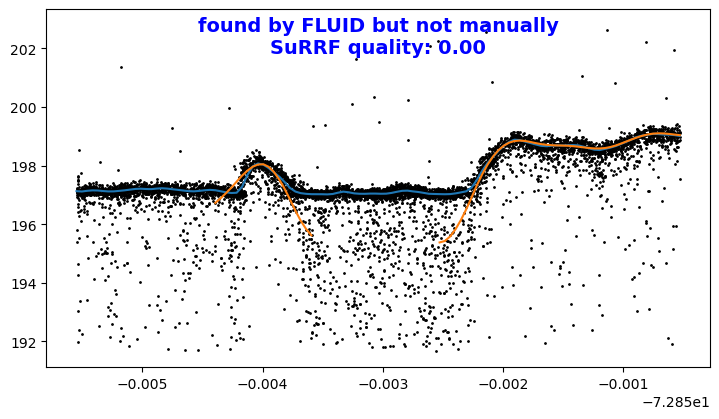

__________________________________________________________________


In [38]:
lakes_overlap = []
counter = 0
trackid = 'ATL03_20190102184312_00810210_006_02_gt2l'
for l in locs:
    if l['qual'] > 0:
        fig,ax = plt.subplots(figsize=[7,4])
        df = df03[(df03.lat > l['xl'][0]) & (df03.lat < l['xl'][1]) & (df03.h > l['yl'][0]) & (df03.h < l['yl'][1])]
        dfdp = dfd[(dfd.lat > l['xl'][0]) & (dfd.lat < l['xl'][1])].copy()
        dfdp.loc[dfdp.conf < 0.3, 'h_fit_bed'] = np.nan
        ax.scatter(df.lat, df.h, s=1, c='k')
        ax.plot(dfdp.lat, dfdp.h_fit_surf, color='C0')
        ax.plot(dfdp.lat, dfdp.h_fit_bed, color='C1')

        if len(dfdp) > 0: 
            lake_quality = dfdp.lake_quality.mean()
            lakes_overlap += list(np.unique(dfdp.lakeid))
            ax.text(0.5, 0.98, 'found by FLUID and manually\nSuRRF quality: %.2f' %lake_quality, transform=ax.transAxes, 
                    fontsize=14, color='g', ha='center', va='top', fontweight='bold')
            thisfn = dfdp.fn.iloc[0]
            print(thisfn)
            print(dfdp.lat.mean())
        else:
            ax.text(0.5, 0.98, 'found manually but not by FLUID', transform=ax.transAxes, fontsize=14, color='r', ha='center', va='top', fontweight='bold')
        
        fig.tight_layout(pad=0)
        counter += 1
        fig.savefig('zzz_evalplots/' + trackid + '_%03d.jpg' % counter, dpi=300)
        plt.close(fig)
        display(fig)
        print('__________________________________________________________________')

for i in np.unique(dfd.lakeid):
    if i not in lakes_overlap:
        dfdp = dfd[dfd.lakeid == i].copy()
        lake_quality = dfdp.lake_quality.mean()
        dfdp.loc[dfdp.conf < 0.3, 'h_fit_bed'] = np.nan
        hrange = dfdp.h_fit_surf.max() - dfdp.h_fit_bed.min()
        hmin = dfdp.h_fit_bed.min() - hrange
        hmax = dfdp.h_fit_bed.max() + hrange
        df = df03[(df03.lat > dfdp.lat.min()) & (df03.lat < dfdp.lat.max()) & (df03.h > hmin) & (df03.h < hmax)]
        fig,ax = plt.subplots(figsize=[7,4])
        ax.scatter(df.lat, df.h, s=1, c='k')
        ax.plot(dfdp.lat, dfdp.h_fit_surf, color='C0')
        ax.plot(dfdp.lat, dfdp.h_fit_bed, color='C1')
        ax.text(0.5, 0.98, 'found by FLUID but not manually\nSuRRF quality: %.2f' % lake_quality, 
                transform=ax.transAxes, fontsize=14, color='b', ha='center', va='top', fontweight='bold')
        fig.tight_layout(pad=0)
        counter += 1
        fig.savefig('zzz_evalplots/' + trackid + '_%03d.jpg' % counter, dpi=300)
        plt.close(fig)
        display(fig)
        print('__________________________________________________________________')

In [13]:
# df_lakes = df.copy()
# maxdepths = []
# for i in range(len(df_lakes)):
# # for i in range(100):
#     print('reading file %5i / %5i' % (i+1, len(df_lakes)), end='\r')
#     fn = df_lakes.iloc[i].file_name
#     lk = dictobj(read_melt_lake_h5(fn))
#     dfd = lk.depth_data.copy()
    
#     isdepth = dfd.depth>0
#     bed = dfd.h_fit_bed
#     bed[~isdepth] = np.nan
#     bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
#     bed[dfd.depth<0.9] = np.nan
#     surf = np.ones_like(dfd.xatc) * lk.surface_elevation
#     surf[~isdepth] = np.nan
#     bed_only = bed[(~np.isnan(surf)) & (~np.isnan(bed))]

#     if len(bed_only) == 0:
#         maxdepths.append(np.nan)
#     else:
#         y_low = np.percentile(bed_only, 5)
#         y_up = lk.surface_elevation
#         ref_index = 1.33
#         max_depth = (y_up - y_low) / ref_index
#         maxdepths.append(max_depth)

# df_lakes['depth_95th_pctl'] = maxdepths
# df_lakes.to_csv('data/lakestats_methods_paper_depth_update.csv', index=False)
# df_lakes

In [14]:
df_lakes = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
# df_lakes = df_lakes[df_lakes.quality_summary > 0]

 AIS 2018-19:  704  2.18  1.85 21.37
 AIS 2020-21:   26  2.23  1.48 14.23
GrIS    2019:  316  4.49  2.78 23.40
GrIS    2020:  173  4.49  3.44 17.30


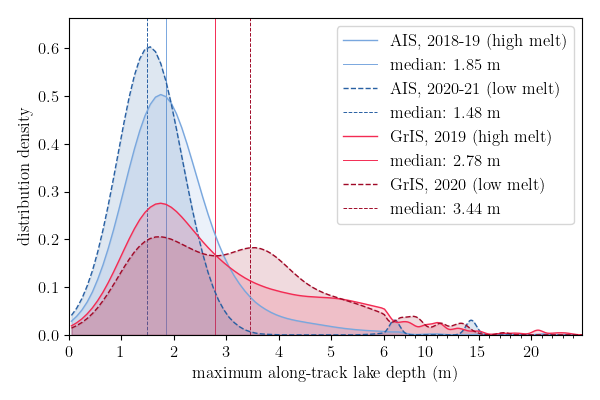

In [16]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
colors = {
    'GrIS': '#D00C33', # Greenland flag
    'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
}
line_sty = {
    'low_melt': '--',
    'high_melt': '-'
}

season_type = {
    '2018-19': 'high_melt',
    '2020-21': 'low_melt',
    '2019': 'high_melt',
    '2020': 'low_melt'
}

melt_seasons = [
    '2018-19',
    '2020-21',
    '2019', 
    '2020',
]

density = True
collapse = True
collapse_start = 6
collapse_factor = 5

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

fig, ax = plt.subplots(figsize=[6,4], dpi=100)
step = 0.25
step_s = 0.1
smooth = 1
uplim = 25
bins = np.arange(0,uplim+step/2,step)
mids = bins[:-1] + np.diff(bins)/2
bins_s = np.arange(0,uplim+step_s-0.1,step_s)
mids_s = bins_s[:-1] + np.diff(bins_s)/2
wdw = int(np.ceil(smooth/step_s))

if collapse: 
    mids_s[mids_s > collapse_start] = collapse_start + (mids_s[mids_s > collapse_start]-collapse_start) / collapse_factor
    coll_labs = np.array([5,10,15,20,25])
    coll_labs = coll_labs[coll_labs > collapse_start]
    coll_ticks = np.arange(0,collapse_start+1)
    coll_ticklabels = np.hstack((coll_ticks, coll_labs))
    coll_ticks = np.hstack((coll_ticks, collapse_start+((coll_labs-collapse_start)/collapse_factor)))
    minor_ticks = np.arange(0, uplim+1).astype(np.float64)
    minor_ticks[minor_ticks > collapse_start] = collapse_start + (minor_ticks[minor_ticks > collapse_start]-collapse_start) / collapse_factor

hdls = []
maxval = 0
medians = []
for melt_season in melt_seasons:
    sheet = 'AIS' if len(melt_season)>4 else 'GrIS'
    dfi = df_lakes[(df_lakes.melt_season == melt_season) & (~np.isnan(df_lakes.depth_95th_pctl))]
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    print('%4s %7s: %4i %5.2f %5.2f %5.2f' % (
        sheet, 
        melt_season, 
        len(dfi), 
        dfi.depth_95th_pctl.mean(), 
        dfi.depth_95th_pctl.median(), 
        dfi.depth_95th_pctl.max()))
    medians.append(dfi.depth_95th_pctl.median())
    depths = np.clip(dfi.depth_95th_pctl, 0, uplim-step/2)
    
    hist = np.histogram(depths, bins=bins, density=density)[0]
    hist_s = np.histogram(depths, bins=bins_s, density=density)[0]
    
    hist_smooth = pd.Series(hist_s).rolling(window=wdw*3, center=True, min_periods=1, win_type='gaussian').mean(std=wdw/2)
    # hdl = ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet], alpha=0.3, label=sheet_name)
    # hdls.append(hdl)

    coladj = 1.3
    amt = coladj if season_type[melt_season] == 'high_melt' else 1/coladj
    thiscol = adjust_lightness(colors[sheet], amount=amt)
    hdl, = ax.plot(mids_s, hist_smooth, color=thiscol, lw=1.0, alpha=1.0,
                   label='%s, %s (%s)'%(sheet,melt_season,season_type[melt_season].replace('_', ' ')), 
                   ls=line_sty[season_type[melt_season]])
    ax.fill_between(mids_s, hist_smooth, color=thiscol, alpha=0.15)
    hdls.append(hdl)
    median = dfi.depth_95th_pctl.median()
    hdl, = ax.plot([median]*2, [0,100], lw=0.7, color=thiscol, 
                   label = 'median: %.2f m' % median,
                   ls=line_sty[season_type[melt_season]], zorder=-100)
    hdls.append(hdl)
    maxval = np.max((maxval, np.max(hist_smooth)))

if collapse:
    ax.set_xticks(coll_ticks)
    ax.set_xticklabels(coll_ticklabels)
    ax.set_xticks(minor_ticks, minor=True)

if density:
    ax.set_ylabel('distribution density')
else:
    ax.set_ylabel('number of lakes per %g m depth bin')
    
ax.set_xlabel('maximum along-track lake depth (m)')
ax.set_xlim((0,np.max(mids_s)))
ax.set_ylim((-0.001, 1.1*maxval))
ax.tick_params(axis='both')

ax.legend(handles=hdls)
fig.tight_layout()

if density:
    fn_plot_out = 'plots/depth_distributions_density.jpg'
else:
    fn_plot_out = 'plots/depth_distributions_counts.jpg'
if collapse:
    fn_plot_out = fn_plot_out.replace('.jpg', '_collapsed.jpg')
fig.savefig(fn_plot_out, dpi=600)

In [140]:
if collapse: 
    mids_s[mids_s > collapse_start] = collapse_start + (mids_s[mids_s > collapse_start]-collapse_start) / collapse_factor
    coll_labs = np.array([5,10,15,20,25])
    coll_labs = coll_labs[coll_labs > collapse_start]
    coll_ticks = np.arange(0,collapse_start+1)
    coll_ticklabels = np.hstack((coll_ticks, coll_labs))
    coll_ticks = np.hstack((coll_ticks, collapse_start+((coll_labs-collapse_start)/collapse_factor)))
    minor_ticks = np.arange(0, uplim+1).astype(np.float64)
    minor_ticks[minor_ticks > collapse_start] = collapse_start + (minor_ticks[minor_ticks > collapse_start]-collapse_start) / collapse_factor
print(['%4g' % x for x in coll_ticks])
print(['%4g' % x for x in coll_ticklabels])
print(minor_ticks)

['   0', '   1', '   2', '   3', '   4', '   5', '   6', '   7', ' 7.6', ' 8.6', ' 9.6', '10.6']
['   0', '   1', '   2', '   3', '   4', '   5', '   6', '   7', '  10', '  15', '  20', '  25']
[ 0.   1.   2.   3.   4.   5.   6.   7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6]


/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999370_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt3r_0043.h5


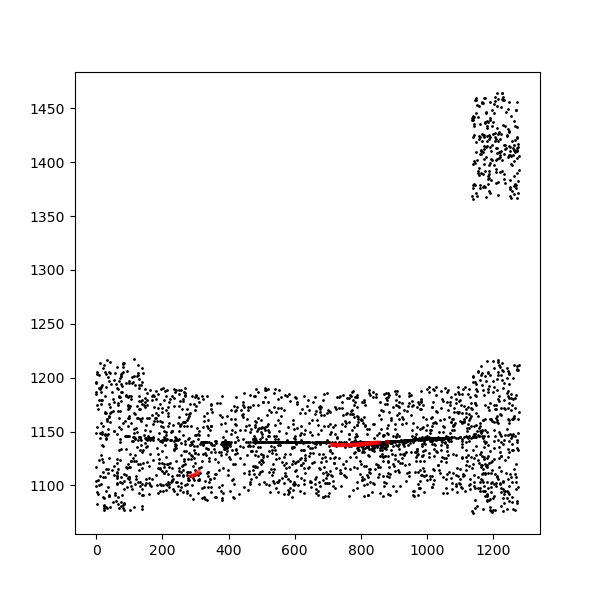

In [10]:
dfi = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
dfi = dfi.sort_values(by='depth_95th_pctl', ascending=False)
for i in [0]:
    fn = dfi.iloc[i].file_name
    print(fn)
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data
    dfd = lk.depth_data.copy()
    
    isdepth = dfd.depth>0
    bed = dfd.h_fit_bed
    bed[~isdepth] = np.nan
    bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
    surf = np.ones_like(dfd.xatc) * lk.surface_elevation
    surf[~isdepth] = np.nan
    bed[np.isnan(surf)] = np.nan
    
    fig, ax = plt.subplots(figsize=[6,6], dpi=100)
    ax.scatter(df.xatc, df.h, s=1, c='k')
    # ax.plot(dfd.xatc, bed, 'r-')
    
    # ax.scatter(dfd.xatc, bed, s=5, c='r', alpha=dfd.conf)
    alph = np.array(dfd.conf)
    alph[alph<0.5] = 0.0
    ax.scatter(dfd.xatc, bed, s=5, color='r', alpha=alph)